In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Latent matrix from metadata

In [2]:
# !ls ../data

In [3]:
filename = '../data/20pct_oct19.csv'

In [4]:
import random
p = 1  # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         filename,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p
)
df.shape

(8490605, 10)

In [5]:
def preprocessing_feat(X, drop_event_time=False):
    if drop_event_time:
        X = X.drop("event_time", axis=1)
    
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')
    return X_preprocessed

In [6]:
X_preprocessed = preprocessing_feat(df,  drop_event_time=True)

/var/folders/p5/qt42vq_56xz89lxgtq0ygbdh0000gn/T/ipykernel_13541/4055017079.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  X_preprocessed['category_code'] = X_preprocessed['category_code'].str.replace('.',' ')


In [7]:
X_preprocessed.shape

(5313956, 9)

## Pricing criterion

In [8]:
def make_column(row):
    if row["price"] < row["25%"]:
        return "low"
    elif row["price"] < row["75%"]:
        return "medium"
    else:
        return "high"

def pricing_criterion(X):
    pricing_guide = X.groupby('category_code')['price'].describe()[["25%", "75%"]].reset_index()
    X_merged = X.merge(pricing_guide, on="category_code", how="right")
    X_merged["price_category"] = X_merged.apply(lambda row: make_column(row), axis=1)
    return X_merged


In [9]:
X_merged = pricing_criterion(X_preprocessed)

del X_preprocessed

In [10]:
def metadata(X):
    X['metadata'] = X[['category_code', 'brand', 'price_category']].apply(lambda x: ' '.join(x), axis = 1)
    return X


In [11]:
X_meta = metadata(X_merged)
X_meta.nunique()

del X_merged

In [12]:
X_meta.set_index(X_meta['product_id'], inplace=True)

In [13]:
print(X_meta.shape)
X_meta.head()

(5313956, 13)


,Unnamed: 0,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,25%,75%,price_category,metadata
product_id,,,,,,,,,,,,,
18300904,1099,view,18300904,2053013558945383017,accessories bag,lenovo,71.04,517302823,3ef9e93a-9613-455c-9161-16a09663ac31,16.32,76.96,medium,accessories bag lenovo medium
28401176,1478,view,28401176,2053013566209917945,accessories bag,karya,100.39,512478069,5327d365-1cb2-4906-ae61-e53b2d539fa9,16.32,76.96,high,accessories bag karya high
28400273,2299,view,28400273,2053013566209917945,accessories bag,karya,95.24,512937756,e405a0d9-e4e3-6176-c72d-2bc8eb82f20e,16.32,76.96,high,accessories bag karya high
28401050,2442,view,28401050,2053013566209917945,accessories bag,karya,54.06,512937756,e405a0d9-e4e3-6176-c72d-2bc8eb82f20e,16.32,76.96,medium,accessories bag karya medium
28401176,2460,view,28401176,2053013566209917945,accessories bag,karya,100.39,512478069,27fbbcb2-fee7-41a2-9b56-69b484e16311,16.32,76.96,high,accessories bag karya high


In [14]:
filename = f'../data/latent_dfs/X_meta_with_{p}pct_data_oct19.csv'
X_meta.to_csv(filename)

### Count Vectorizer

In [15]:
count = CountVectorizer()
count_matrix = count.fit_transform(X_meta['metadata'])

del count

In [16]:
count_df_1 = pd.DataFrame(count_matrix.toarray(), index=X_meta.product_id.tolist())
print(count_df_1.shape)

del count_matrix
del X_meta

(5313956, 1827)


In [17]:
count_df_1 = count_df_1.reset_index()

In [18]:
count_df_1.sort_values(by='index', inplace=True)

In [19]:
to_divide = count_df_1.shape[0] // 2
to_divide

2656978

In [20]:
count_df_1_p1 = count_df_1.iloc[:to_divide,:]
count_df_1_p1

,index,0,1,2,3,4,5,6,7,8,...,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826
4066373,1000978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4012002,1000978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4512985,1000978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4366239,1000978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4591822,1000978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1781947,1600557,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1778850,1600557,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1776782,1600557,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1786693,1600557,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
count_df_1_p2 = count_df_1.iloc[to_divide:,:]
count_df_1_p2

,index,0,1,2,3,4,5,6,7,8,...,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826
1793357,1600557,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1802625,1600557,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1779914,1600557,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1786772,1600557,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1799437,1600557,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915008,60500007,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916056,60500010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1915924,60500010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1915923,60500010,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
count_df_1_p1.drop_duplicates(subset='index', keep='first', inplace=True) 

/var/folders/p5/qt42vq_56xz89lxgtq0ygbdh0000gn/T/ipykernel_13541/1731946799.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df_1_p1.drop_duplicates(subset='index', keep='first', inplace=True)


In [23]:
count_df_1_p2.drop_duplicates(subset='index', keep='first', inplace=True) 

/var/folders/p5/qt42vq_56xz89lxgtq0ygbdh0000gn/T/ipykernel_13541/621231526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df_1_p2.drop_duplicates(subset='index', keep='first', inplace=True)


In [24]:
count_df_1 = pd.concat([count_df_1_p1, count_df_1_p2])

In [25]:
del count_df_1_p1
del count_df_1_p2

In [26]:
count_df_1.drop_duplicates(subset='index', keep='first', inplace=True) 
count_df_1["product_id"] = count_df_1["index"]
count_df_1.drop("index", axis=1, inplace=True)
count_df_1.head()

,0,1,2,3,4,5,6,7,8,9,...,1818,1819,1820,1821,1822,1823,1824,1825,1826,product_id
4066373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1000978
3162821,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1001588
4744106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1001606
2473248,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1002042
3475488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1002062


In [27]:
count_df_1.shape

(52817, 1828)

### Dimensionality reduction

In [28]:
n = 50
svd = TruncatedSVD(n_components=n)
latent_df_1 = svd.fit_transform(count_df_1.set_index("product_id"))

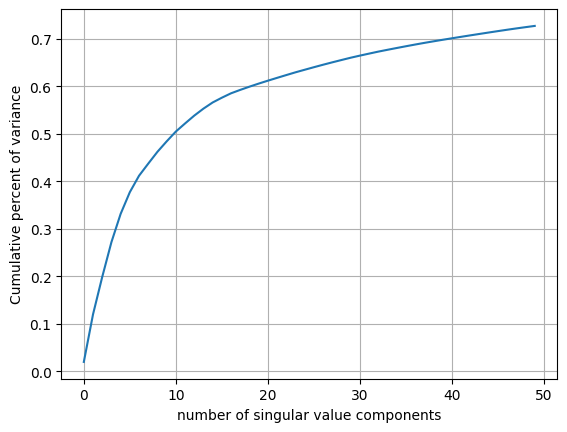

In [29]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [30]:
del svd

In [31]:
#count_df_1=count_df_1.set_index("product_id")
#count_df_1.head()
df_for_latent1 = count_df_1.product_id.tolist()

del count_df_1

In [32]:
#n defined above
#n = 50
latent_df_1 = pd.DataFrame(latent_df_1[:,0:n], index=df_for_latent1)
print(latent_df_1.shape)
latent_df_1

del df_for_latent1

(52817, 50)


In [33]:
latent_df_1.reset_index().drop_duplicates().shape

(52817, 51)

In [34]:
latent_df_1

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
1000978,1.011997,-0.623184,-0.380176,0.486457,-0.115748,-0.212726,-0.037781,0.002280,0.096322,-0.012538,...,-0.021127,-0.148078,0.101628,0.095404,0.192290,-0.141239,-0.019931,-0.209001,0.039352,-0.287247
1001588,0.450582,-0.154148,0.113206,1.006491,0.751239,0.208610,0.073950,0.034433,0.013401,0.007141,...,-0.034642,-0.096371,-0.043830,-0.010137,-0.062971,0.124478,0.032251,0.046620,0.012112,-0.003206
1001606,1.003073,-0.623449,-0.369852,0.495251,-0.126210,-0.216949,-0.036066,0.007362,0.085205,-0.005006,...,-0.030855,-0.044015,-0.001673,-0.019508,-0.036033,0.010694,0.029710,0.062039,-0.134516,0.169932
1002042,0.466080,-0.143793,0.103378,1.014509,0.748322,0.207734,0.060810,0.026635,0.023192,-0.001750,...,-0.010798,-0.150577,0.108524,0.096416,0.194678,-0.137793,-0.018459,-0.218849,0.032258,-0.301445
1002062,0.466080,-0.143793,0.103378,1.014509,0.748322,0.207734,0.060810,0.026635,0.023192,-0.001750,...,-0.010798,-0.150577,0.108524,0.096416,0.194678,-0.137793,-0.018459,-0.218849,0.032258,-0.301445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60500004,0.257847,0.084290,0.274721,0.336356,0.417794,0.681381,1.344580,-0.292457,-0.003615,0.042007,...,0.008158,-0.005644,0.007655,-0.004312,-0.011380,0.009707,-0.012894,-0.003327,-0.098923,-0.014408
60500005,0.257144,0.084451,0.274665,0.336173,0.417651,0.679306,1.336742,-0.289933,-0.003894,0.042173,...,0.008162,-0.003565,0.008190,-0.005194,-0.014579,0.010160,-0.005851,-0.001854,-0.098273,-0.018379
60500006,0.257183,0.084441,0.274685,0.336204,0.417682,0.679468,1.337279,-0.290098,-0.003882,0.042199,...,0.008191,-0.003584,0.008227,-0.005253,-0.014679,0.010202,-0.005890,-0.001822,-0.098854,-0.018442
60500007,0.258498,0.084759,0.274473,0.336144,0.415244,0.680488,1.344352,-0.289281,-0.004041,0.039671,...,0.009507,-0.003518,0.008604,-0.007273,-0.014613,0.009032,-0.005846,-0.000939,-0.099011,-0.015094


In [35]:
filename = f'../data/latent_dfs/latent_df_1_with_{p}pct_data_{n}_svd_components_oct19.csv'
latent_df_1.to_csv(filename)

In [36]:
#X_meta['product_id'].nunique()

# Latent matrix from event types

In [37]:
def preprocessing_event(X):
    X_preprocessed = X.dropna(subset = ['category_code', 'brand']) #tbd!!
    X_preprocessed = X_preprocessed.drop_duplicates()
    return X_preprocessed

In [38]:
df_event = preprocessing_event(df)
df_event.user_id.nunique()

del df

In [39]:
dct = {'view': 1, 'cart': 3, 'purchase': 5}

In [40]:
df_event['rating'] = df_event['event_type'].map(dct)

In [41]:
df_event["rating"].sum()

6078864

In [42]:
# df_rating.shape

In [43]:
# df_rating = df_event.pivot_table(values='rating',
#                                  index='product_id',
#                                  columns='user_id',
#                                  aggfunc="sum").fillna(0)
# df_rating

In [44]:
df_event.nunique()

Unnamed: 0       5313956
event_time       2031530
event_type             3
product_id         52817
category_id          246
category_code        126
brand               1655
price              42009
user_id          1391913
user_session     2935510
rating                 3
dtype: int64

In [45]:
df_event.drop_duplicates(subset='product_id',inplace=True)
df_event.nunique()

Unnamed: 0       52817
event_time       49927
event_type           3
product_id       52817
category_id        246
category_code      126
brand             1654
price            15675
user_id          37582
user_session     43111
rating               3
dtype: int64

In [46]:
%%time

df_rating = df_event.pivot(values='rating',
               index='product_id',
               columns='user_id').fillna(0)

df_rating

CPU times: user 13.2 s, sys: 11.5 s, total: 24.7 s
Wall time: 26.6 s


user_id,240236728,290715762,303037100,306441847,348612112,359660585,379624017,388541724,393601619,395944286,...,566171965,566174602,566175735,566175944,566194918,566197006,566204912,566207551,566208807,566223857
product_id,,,,,,,,,,,,,,,,,,,,,
1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60500004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60500005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60500006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
df_rating.sum().reset_index()[0].sum()

53661.0

In [48]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    53661
dtype: int64

In [49]:
df_event.groupby("user_id").agg({"rating":sum}).sort_values(by="rating").sum()

rating    53661
dtype: int64

In [50]:
df_rating.reset_index()

user_id,product_id,240236728,290715762,303037100,306441847,348612112,359660585,379624017,388541724,393601619,...,566171965,566174602,566175735,566175944,566194918,566197006,566204912,566207551,566208807,566223857
0,1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1001606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1002042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1002062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52812,60500004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52813,60500005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52814,60500006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52815,60500007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
df_rating

user_id,240236728,290715762,303037100,306441847,348612112,359660585,379624017,388541724,393601619,395944286,...,566171965,566174602,566175735,566175944,566194918,566197006,566204912,566207551,566208807,566223857
product_id,,,,,,,,,,,,,,,,,,,,,
1000978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60500004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60500005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60500006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# df_rating.index

In [53]:
# df_rating.columns

In [54]:
# df_rating_reset_index_no_productid_col = df_rating.reset_index().iloc[:,1:]
# df_rating_reset_index_no_productid_col

In [55]:
# n_s = 75
# svd = TruncatedSVD(n_components=n_s)
# latent_df_3 = svd.fit_transform(df_rating_reset_index_no_productid_col)
# latent_df_3

In [56]:
n_s = 100
svd = TruncatedSVD(n_components=n_s)
latent_df_2 = svd.fit_transform(df_rating)

In [57]:
latent_df_2

array([[ 3.45711636e-12, -7.64730259e-12, -5.22980696e-11, ...,
        -7.04297447e-11,  2.91140514e-10,  1.42154647e-10],
       [-3.41417549e-10, -4.91596339e-10,  1.28120939e-09, ...,
         2.50471739e-08, -6.20840359e-09,  2.98541572e-08],
       [ 4.43251454e-12, -6.37688089e-12, -3.47244058e-11, ...,
        -1.76336320e-10,  6.57046797e-10,  1.99430263e-10],
       ...,
       [-2.13579789e-09,  1.73129735e-09,  7.26246227e-09, ...,
        -3.23876160e-07,  9.26049936e-08, -3.33694114e-08],
       [-2.13579789e-09,  1.73129735e-09,  7.26246227e-09, ...,
        -3.23876160e-07,  9.26049936e-08, -3.33694114e-08],
       [-2.65780209e-11,  3.37799095e-10,  1.54584210e-09, ...,
        -3.04369092e-08,  6.39496994e-09,  1.76506062e-08]])

In [58]:
# latent_df_2 = pd.DataFrame(latent_df_2, index=df_rating.index)
# latent_df_2

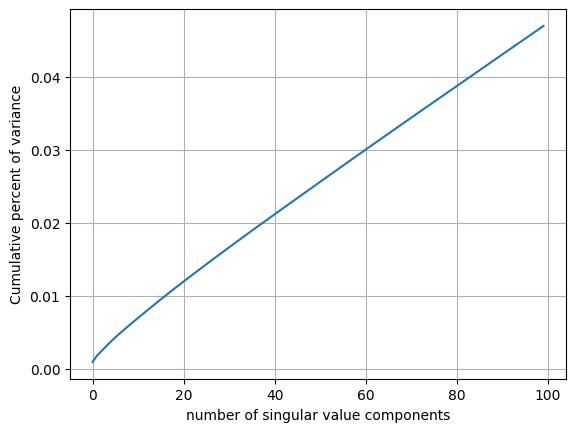

In [59]:
plt.plot(svd.explained_variance_ratio_.cumsum())
plt.xlabel('number of singular value components')
plt.ylabel('Cumulative percent of variance')   
plt.grid()
plt.show()

In [60]:
del svd

In [61]:
latent_df_2 = pd.DataFrame(latent_df_2, index=df_rating.reset_index().product_id.tolist())
latent_df_2.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
1000978,3.457116e-12,-7.647303e-12,-5.229807e-11,-5.223009e-12,7.521721e-11,4.100482e-11,2.002182e-11,2.784693e-12,3.707997e-10,1.602469e-11,...,3.657432e-11,-2.287473e-10,3.632910e-10,3.954256e-10,-7.914660e-11,3.949634e-10,-9.391689e-11,-7.042974e-11,2.911405e-10,1.421546e-10
1001588,-3.414175e-10,-4.915963e-10,1.281209e-09,4.920853e-10,3.701399e-09,1.432284e-08,5.503048e-09,-3.178901e-09,-7.128125e-09,-8.080676e-09,...,-5.754571e-08,-1.927902e-08,4.152988e-08,1.843542e-08,2.513252e-08,4.960889e-08,-1.548731e-08,2.504717e-08,-6.208404e-09,2.985416e-08
1001606,4.432515e-12,-6.376881e-12,-3.472441e-11,3.290277e-11,-4.962909e-11,3.091941e-11,-1.784861e-11,-1.440861e-10,9.653236e-11,-2.458111e-11,...,1.754743e-10,-5.235417e-10,-8.677409e-11,6.597006e-10,6.133764e-10,2.535012e-10,-1.626082e-10,-1.763363e-10,6.570468e-10,1.994303e-10
1002042,1.235610e-11,-1.841875e-12,2.211459e-11,3.281866e-11,5.148971e-12,-1.277910e-10,-2.298846e-11,-1.277047e-10,-8.637708e-12,-9.145993e-11,...,5.049348e-10,1.240354e-10,-9.891541e-10,1.354112e-10,1.585830e-10,-2.993687e-10,-7.985069e-10,6.287094e-10,5.029197e-10,3.445676e-10
1002062,-4.436925e-12,-2.987696e-12,-5.152762e-11,-7.689036e-11,5.316302e-11,1.327261e-10,4.074853e-11,-2.240237e-11,2.214909e-10,-5.582463e-11,...,-3.713891e-10,9.041996e-13,-9.825824e-10,-6.583270e-10,1.842813e-10,6.051739e-11,3.975980e-11,-1.179401e-11,-1.539785e-10,-4.021296e-11


In [62]:
latent_df_2.shape

(52817, 100)

In [63]:
filename_2 = f'../data/latent_dfs/latent_df_2_with_{p}pct_data_{n_s}_svd_components_oct19.csv'
latent_df_2.to_csv(filename_2)

# Apply Cosine Similarity in Content and Collaborative Matrices


In [ ]:
product_id=5100337

In [ ]:
# Get the latent vectors for "Toy Story" from content and collaborative matrices
v1 = np.array(latent_df_1.loc[product_id]).reshape(1, -1)
v2 = np.array(latent_df_2.loc[product_id]).reshape(1, -1)

# Compute the cosine similarity of this movie with the others in the list
sim1 = cosine_similarity(latent_df_1, v1).reshape(-1)
sim2 = cosine_similarity(latent_df_2, v2).reshape(-1)

In [ ]:
dictDf_1 = {'features': sim1} 
recommendation_df_1 = pd.DataFrame(dictDf_1, index = latent_df_1.index)
# recommendation_df_1.sort_values('features', ascending=False, inplace=True)

In [ ]:
dictDf_2 = {'ratings': sim2} 
recommendation_df_2 = pd.DataFrame(dictDf_2, index = latent_df_2.index)
# recommendation_df_2.sort_values('ratings', ascending=False, inplace=True)

In [ ]:
weight_features = 0.8

In [ ]:
recommendation_combined = pd.merge(recommendation_df_1, recommendation_df_2, left_index=True, right_index=True)
recommendation_combined['hybrid'] = ((weight_features*recommendation_combined['features'] + (1-weight_features)*recommendation_combined['ratings']))

In [ ]:
recommendation_combined.sort_values('ratings', ascending=False, inplace=True)
recommendation_combined

In [ ]:
recommendation_combined.head()

In [ ]:
def top_n_products(rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inouts for ranking: 'features', 'ratings', 'hybrid'"""
    
    feat_idx = rec_df.sort_values(ranking, ascending=False).index
    
    
    return feat_idx
    
#     for i in feat_idx:
#         meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
#         lst = []
#         lst.append(meta_text)
#         return lst

In [ ]:
indexes = top_n_products(recommendation_combined, X_meta, ranking='features')

In [ ]:
len(indexes)

In [ ]:
X_meta[X_meta.index.isin(indexes)]['metadata']

In [ ]:
# X_meta.head()

In [ ]:
def top_n_products(rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inputs for ranking: 'features', 'ratings', 'hybrid'"""

    feat_idx = rec_df.sort_values(ranking, ascending=False).index
    
    counter = 0
    
    product_ids=[]
    metas=[]
    prices=[]
    
    for i in feat_idx:
        meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
        price = meta_df[meta_df['product_id'] == i][['price']].iloc[0,:][0]
        
#         if counter == 0:
#             print(f"Top {n} recommendations for product_id {product_id}:")
#             print(f"{i} - {meta_text} {price} \n")
#             print("-----------------------")

#         else:
#             print(f"Rec {counter}) {i} - {meta_text} {price}")
        
        product_ids.append(i)
        metas.append(meta_text)
        prices.append(price)
        
        counter += 1
    
    return pd.DataFrame({'product_id':product_ids, 'meta_text':metas, 'price':prices})

In [ ]:
# top_n_products(recommendation_combined, X_meta, ranking='features')

In [ ]:
# new_df = top_n_products(recommendation_combined, X_meta, ranking='features')

In [ ]:
# new_df.drop_duplicates('meta_text').iloc[:10,:]

In [ ]:
def top_n_products(rec_df, meta_df, n=10, ranking='hybrid'):
    
    """Valid inputs for ranking: 'features', 'ratings', 'hybrid'"""

    feat_idx = rec_df.sort_values(ranking, ascending=False).index
    
    counter = 0
    
    product_ids=[]
    metas=[]
    prices=[]
    
    for i in feat_idx:
        meta_text = meta_df[meta_df['product_id'] == i][['metadata']].iloc[0,:][0]
        price = meta_df[meta_df['product_id'] == i][['price']].iloc[0,:][0]
        
#         if counter == 0:
#             print(f"Top {n} recommendations for product_id {product_id}:")
#             print(f"{i} - {meta_text} {price} \n")
#             print("-----------------------")

#         else:
#             print(f"Rec {counter}) {i} - {meta_text} {price}")
        
        product_ids.append(i)
        metas.append(meta_text)
        prices.append(price)
        
        counter += 1
    
    new_df = pd.DataFrame({'product_id':product_ids, 'meta_text':metas, 'price':prices}).drop_duplicates('meta_text').iloc[:n,:]
    return new_df.reset_index().drop(columns='index')

In [ ]:
# top_n_products(recommendation_combined, X_meta, ranking='features', n=10)